In [1]:
from sklearn.preprocessing import StandardScaler
from utils.ds_clean import clean_ds
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt




2024-04-11 19:28:54.193480: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 19:28:54.193769: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 19:28:54.196240: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 19:28:54.225679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 19:28:54.774080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
df_tets = clean_ds(pd.read_csv('data/aapl_5m_test.csv'))
model_buy = load_model('deep_learning/model_buy_rnn.keras')
model_sell = load_model('deep_learning/model_sell_rnn.keras')

close_data_test = df_tets[['Timestamp','Close', 'X_t-1', 'X_t-2', 'X_t-3', 'X_t-4' ,'X_t-5','RSI', 'Y_BUY']].dropna()
cl_dat_test = close_data_test.copy()

x_buy_test = cl_dat_test.drop(columns=['Timestamp','Y_BUY']).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_buy_test)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

close_data_test['Y_BUY_PRED_CNN'] = (model_buy.predict(X_reshaped)) > 0.5
close_data_test = close_data_test.drop(columns=['Y_BUY','RSI','X_t-1','X_t-2','X_t-3','X_t-4' ,'X_t-5'])
close_data_test['Y_SELL_PRED_CNN'] = (model_sell.predict(X_reshaped)) > 0.5

#convertir a booleano


2024-04-11 19:28:55.400630: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-11 19:28:55.400852: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
614/614 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


In [3]:
close_data_test

,Timestamp,Close,Y_BUY_PRED_CNN,Y_SELL_PRED_CNN
27,1672764300,124.849998,True,False
28,1672764600,124.599899,True,False
29,1672764900,124.742500,True,False
30,1672765200,124.730003,True,False
31,1672765500,124.930000,True,False
...,...,...,...,...
19674,1703882400,192.500000,False,False
19675,1703882700,192.510299,False,False
19676,1703883000,192.369995,False,False
19677,1703883300,192.520004,False,False


Best buy/sell overall strategy: rnn_strategy with value: 5635457.340371052
Best buy/sell strategy parameters: {'stop_loss': 0.03202113504755525, 'take_profit': 0.04768956604374807, 'n_shares': 101}

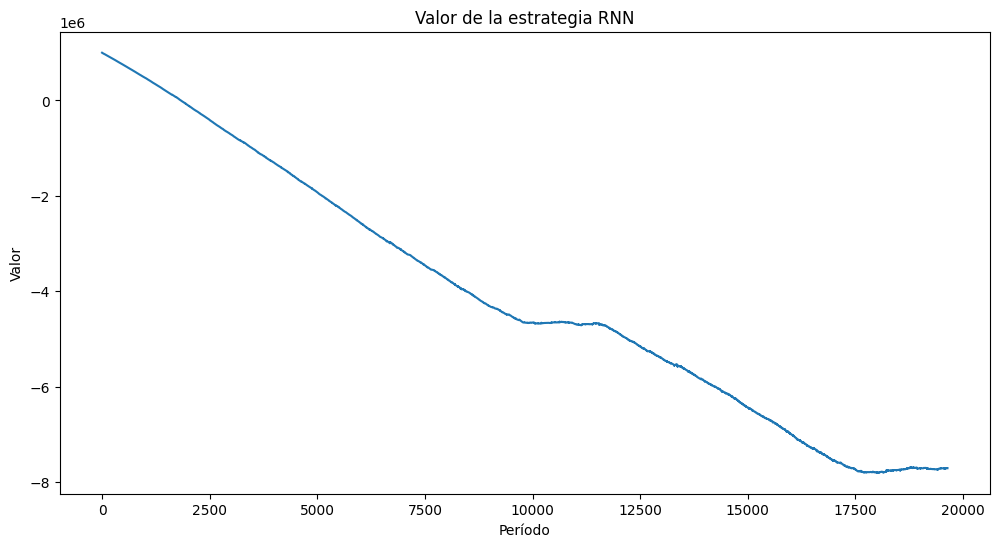

Valor de la estrategia RNN:  -7708191.3221269045


In [4]:
cash = 1_000_000
active_operations = []
com = 0.00125  # comision en GBM
strategy_value = [1_000_000]
stop_loss = 0.03451137396108058
take_profit = 0.007335240907359543
n_shares = 9

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        # self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

for i, row in close_data_test.iterrows():
    # Close Operations
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if op.stop_loss > row.Close:
                cash += row.Close * op.n_shares * (1 - com)
            elif op.take_profit < row.Close:
                cash += row.Close * op.n_shares * (1 - com)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if op.stop_loss < row.Close:
                cash -= row.Close * op.n_shares * (1 + com)
            elif op.take_profit > row.Close:
                cash -= row.Close * op.n_shares * (1 + com)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    # Open Operations
    if row.Y_BUY_PRED_CNN:
        n_shares = n_shares
        stop_loss = row.Close * (1 - stop_loss)
        take_profit = row.Close * (1 + take_profit)
        active_operations.append(
            Operation('Long', row.Close, row.Timestamp, n_shares, stop_loss, take_profit))
        cash -= row.Close * n_shares * (1 + com)
    elif row.Y_SELL_PRED_CNN:
        n_shares = n_shares
        stop_loss = row.Close * (1 + stop_loss)
        take_profit = row.Close * (1 - take_profit)
        active_operations.append(
            Operation('Short', row.Close, row.Timestamp, n_shares, stop_loss, take_profit))
        cash += row.Close * n_shares * (1 - com)

    total_value = len(active_operations) * row.Close 
    strategy_value.append(cash + total_value)
    
plt.figure(figsize=(12, 6))
plt.plot(strategy_value)
plt.title('Valor de la estrategia RNN')
plt.xlabel('Período')
plt.ylabel('Valor')
plt.show()
print("Valor de la estrategia RNN: ", strategy_value[-1])